# Amazon Fine Food Reviews


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review

## Importing libraries and loading the dataset :
* Cleaning and handling deduplication of data is already performed.

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn import datasets, neighbors
import plotly
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

C:\Users\Prakhar\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", conn)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [3]:
data.shape

(364171, 12)

In [4]:
# Sampling the data :
sample_data = data.sample(n=5000)
sample_data['Score'].value_counts()

positive    4253
negative     747
Name: Score, dtype: int64

In [5]:
sample_data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
9168,51865,56341,B00016Q6EM,A1Y87LCA1U979O,"DenetteJG ""DenetteJG""",3,3,positive,1267660800,Yay Popcorn salt!,It's really difficult to find plain popcorn sa...,b'realli difficult find plain popcorn salt stu...
228681,149331,162021,B002912506,AUEUAOWRTQZ8E,I read cookbooks for fun,1,1,positive,1273449600,This wouldn't normally get 5 stars but . . .,it's 136 calories for the whole pint!!! For an...,b'calori whole pint anyon know ice cream know ...


## Time Based Splitting :

In [6]:
# Sorting the sample data using Time column
sorted_sample = sample_data.sort_values(by='Time')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1030,443669,479730,B00005U2FA,A7BP01VQO33U,Caleb,11,11,positive,1022112000,Way To Go Guys!,I'm never dissapointed with the great gadgets ...,b'never dissapoint great gadget compani come b...
355,346034,374336,B00004CI84,API663PFYRQCP,Donn Hart,66,67,positive,1037750400,"Say it once, say it twice, third time's the ch...",When this movie first came out about fifteen y...,b'movi first came fifteen year ago father own ...


In [7]:
# Getting the Labels i.e the Score out of the dataframe.
y = sorted_sample['Score']
# Removing the Labels i.e the Score Column from the dataframe as we wont need it to train a KNN.
sorted_sample = sorted_sample.drop(columns='Score')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
1030,443669,479730,B00005U2FA,A7BP01VQO33U,Caleb,11,11,1022112000,Way To Go Guys!,I'm never dissapointed with the great gadgets ...,b'never dissapoint great gadget compani come b...
355,346034,374336,B00004CI84,API663PFYRQCP,Donn Hart,66,67,1037750400,"Say it once, say it twice, third time's the ch...",When this movie first came out about fifteen y...,b'movi first came fifteen year ago father own ...


In [8]:
# Splitting into Test, Train and Cross-Validation set -
x_train = sorted_sample[0:3000]
y_train = y[0:3000]
x_test = sorted_sample[3000:5000]
y_test = y[3000:5000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (3000, 11)
Test Set -  (2000, 11)


## Bag of Words (BoW) :

In [9]:
# Generating bag of words features.
count_vect = CountVectorizer()
bow_train = count_vect.fit_transform(x_train['CleanedText'].values)
bow_train.shape

(3000, 7718)

In [10]:
bow_test = count_vect.transform(x_test['CleanedText'].values)
bow_test.shape

(2000, 7718)

#### Random Forest on Bow :

In [12]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = [x for x in range(1, 21)]
base_ln

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [13]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, bow_train, y_train, cv = 3, scoring = 'accuracy')
    cv_scores.append(scores.mean())

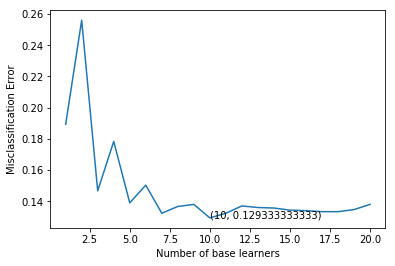

In [16]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]
optimal_learners = base_ln[error.index(min(error))]
plt.plot(base_ln, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [17]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(bow_train, y_train)
clf.score(bow_test, y_test)

0.85250000000000004

##### Conclusions -
* The general trend of error is that it first decreases as the base learners increase then reaches a minimum point and then starts increasing.
* The best classifiers is obtained when base learners = 10 and accuracy is 85.25 %

#### Gradient Boosted Decision Trees (GBDT) :

In [18]:
# Learning rate values ->
lrv = [x/10 for x in range(1,11)]
lrv

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [19]:
# Max-depth values- >
mxd = [x for x in range(1,6)]
mxd

[1, 2, 3, 4, 5]

In [20]:
# Using gridSearchCv to get optimal parameters ->
from sklearn.model_selection import GridSearchCV
params = {'n_estimators': base_ln, 'learning_rate': lrv, 'max_depth': mxd}
clf = XGBClassifier()
model = GridSearchCV(clf, params)
model.fit(bow_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [21]:
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=20,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
# Evaluating the model
model.score(bow_test, y_test)

0.876

##### Conclusions -
* GBDT's provided 2% increase in accuracy over the random forest. note - the optimal base learners found using Gridsearch was 20 so it may be possible to have higher accuracy if base learners are more. But we only checked till 20 so thats the highest we got.
* Learning rate (optimal) - 0.8
* Max_depth was found to be 5.

## TFIDF :

In [23]:
# Generating TFIDF features.
tfidf = TfidfVectorizer()
tf_train = tfidf.fit_transform(x_train['CleanedText'].values)
tf_train.shape

(3000, 7718)

In [24]:
tf_test = tfidf.transform(x_test['CleanedText'].values)
tf_test.shape

(2000, 7718)

#### Random Forest :

In [25]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, tf_train, y_train, cv = 3, scoring = 'accuracy')
    cv_scores.append(scores.mean())

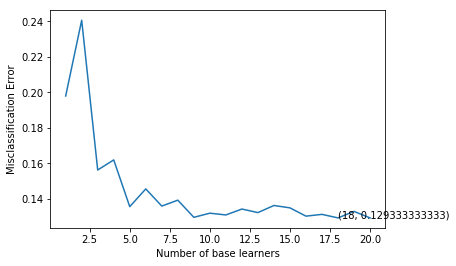

In [26]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]
optimal_learners = base_ln[error.index(min(error))]
plt.plot(base_ln, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [33]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(tf_train, y_train)
clf.score(tf_test, y_test)

0.86050000000000004

##### Conclusions -
* The accuracy for Random Forest is higher for TFIDF than BoW but not by much.
* from the plot it is seen that the error decreases as the number of base learners increase. (Generally)
* Accuracy on test data - 86.05 %
* Optimal number of base Learners - 18

#### GBDT :

In [35]:
# Training GBDT using XGBClassifier
clf = XGBClassifier()
model = GridSearchCV(clf, params)
model.fit(tf_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
# Getting the best model
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=13,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [37]:
# Evaluating the model
model.score(tf_test, y_test)

0.87

##### Conclusions - 
* Accuracy obtained with tfidf on test data - 87 %.
* Optimal learning rate, max_depth and base learners are 0.5, 4, 13 respectively.

## Word2Vec :
* We will train W2V on our train dataset.

In [38]:
# removing html tags and apostrophes if present.
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    sentence = sentence.decode('utf-8')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [40]:
# converting the train set into clean form which does not contain html tags etc.
import gensim
i=0
list_of_sent_train=[]
for sent in x_train['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_train.append(filtered_sentence)

C:\Users\Prakhar\Anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning:

detected Windows; aliasing chunkize to chunkize_serial



In [41]:
# Doing the same for test dataset.
list_of_sent_test=[]
for sent in x_test['CleanedText'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [42]:
# Training the wor2vec model using train dataset
w2v_model=gensim.models.Word2Vec(list_of_sent_train,min_count=5,size=20, workers=4) 

### Avg-W2V :

In [43]:
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
    
print (len(sent_vectors_train))
print (len(sent_vectors_train[0]))

3000
20


In [44]:
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this test
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
    
print (len(sent_vectors_test))
print (len(sent_vectors_test[0]))

2000
20


#### Random Forest :

In [45]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, sent_vectors_train, y_train, cv = 3, scoring = 'accuracy')
    cv_scores.append(scores.mean())

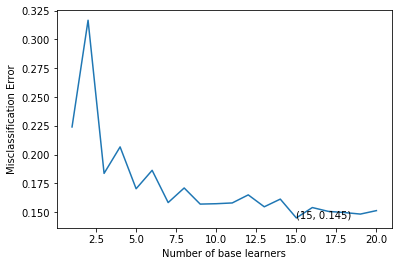

In [46]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]
optimal_learners = base_ln[error.index(min(error))]
plt.plot(base_ln, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [47]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(sent_vectors_train, y_train)
clf.score(sent_vectors_test, y_test)

0.83050000000000002

##### Conclusions -
* AVG-W2V has a lower accuracy than BoW, TFIDF of 83.05 %
* Optimal number of base learners are 15 obtained using Grid Search.

#### GBDT :

In [49]:
# Training GBDT using XGBClassifier
clf = XGBClassifier()
model = GridSearchCV(clf, params)
model.fit(np.array(sent_vectors_train), y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
# Getting the best model
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=15,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [51]:
# Evaluating the model
model.score(np.array(sent_vectors_test), y_test)

0.83650000000000002

##### Conclusions - 
* Accuracy on test data for GBDT - 83.65 similar to random forest. (slight higher).
* Learning rate - 0.2
* Max_depth - 2
* number of base learners - 15.

### TFIDF W2V :

In [52]:
# We will first create tfidf w2v features.
tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(x_train['CleanedText'].values)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

In [53]:
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_train: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    weight_sum = 0.0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_train))
print (len(tfidf_sent_vectors_train[0]))
print (tfidf_sent_vectors_train[0])

3000
20
[ 0.65410614 -0.01043566  0.01478291 -0.28580248 -0.89881299  0.06860017
  0.00130414  0.24219334  0.33533235  0.20646828 -0.60895102 -0.53720265
 -0.7104381   0.88389532  0.47657046  0.22188662 -0.3725661   0.19016365
 -0.36450262 -1.05876352]


In [54]:
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(20) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
    
print (len(tfidf_sent_vectors_test))
print (len(tfidf_sent_vectors_test[0]))
print (tfidf_sent_vectors_test[0])

C:\Users\Prakhar\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: RuntimeWarning:

invalid value encountered in true_divide



2000
20
[ 0.84957035 -0.07690596  0.08393382 -0.39314708 -1.23229534  0.07888357
 -0.03129847  0.26554353  0.42697327  0.30679411 -0.8124818  -0.66576839
 -0.86526788  1.18806736  0.55017471  0.2929913  -0.52578221  0.29200714
 -0.42873297 -1.38273554]


#### Random forest :

In [55]:
# K - Fold Cross Validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, tfidf_sent_vectors_train, y_train, cv = 3, scoring = 'accuracy')
    cv_scores.append(scores.mean())

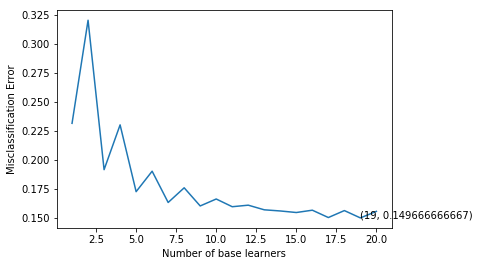

In [56]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]
optimal_learners = base_ln[error.index(min(error))]
plt.plot(base_ln, error)
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [58]:
# Training the best model and calculating error on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(tfidf_sent_vectors_train, y_train)
# Removing nan values from test data.
tfidf_sent_vectors_test = np.array(tfidf_sent_vectors_test)
tfidf_sent_vectors_test = np.nan_to_num(tfidf_sent_vectors_test)
clf.score(tfidf_sent_vectors_test, y_test)

0.77900000000000003

##### Conclusions -
* Accuracy for RF is shockingly low on test data - 77.9 %
* Base Learners (optimal) - 19

#### GBDT :

In [59]:
# Training GBDT using XGBClassifier
clf = XGBClassifier()
model = GridSearchCV(clf, params)
model.fit(np.array(tfidf_sent_vectors_train), y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_depth': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
# Getting the best model
model.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.6, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=9,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
# Evaluating the model
model.score(np.array(tfidf_sent_vectors_test), y_test)

0.83399999999999996

##### Conclusions -
* The accurac of GBDT is higher than RF using TFIDF W2V - 83.39 %
* Learning Rate - 0.6
* Max_depth - 2
* Number of base learners - 9

<table>
    <tr>
        <th>Model</th><th> Random forest Information </th><th> GBDT Information </th>
    </tr>
    <tr>
        <td>Bow</td> <td>Base Learners - 10</td> <td>Base Learners - 20, Learning rate - 0.8, Max_depth - 5</td>
    </tr>
    <tr>
        <td>TFIDF</td> <td>Base Learners - 18</td> <td>Base Learners - 13, Learning rate - 0.5, Max_depth - 4</td>
    </tr>
    <tr>
        <td>AVG-W2V</td> <td>Base Learners - 15</td> <td>Base Learners - 15, Learning rate - 0.2, Max_depth - 2</td>
    </tr>
    <tr>
        <td>TFIDF-W2V</td> <td>Base Learners - 19 </td> <td>Base Learners - 9, Learning rate - 0.6 , Max_depth - 2</td>
    </tr>
</table>